In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Tạo dữ liệu tài chính MB Bank
data = {
    "Năm": [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    "Tổng tài sản": [
        256258500000000, 313877828000000, 362325062000000,
        411487575000000, 494982162000000, 607140419000000,
        728532373000000, 944953640000000
    ],
    "Tổng nợ phải trả": [
        229670054000000, 284276658000000, 328152204000000,
        371601761000000, 444882667000000, 544654396000000,
        648919154000000, 848242481000000
    ],
    "Vốn chủ sở hữu": [
        25351943000000, 29601170000000, 34172858000000,
        39885814000000, 50099495000000, 62486023000000,
        79613219000000, 96711159000000
    ],
    "Thu nhập lãi và các khoản tương tự": [
        15552477000000, 19876026000000, 24824365000000,
        31196604000000, 32767393000000, 38464932000000,
        52485812000000, 69143043000000
    ],
    "Chi phí lãi và tương tự": [
        7573533000000, 8657074000000, 10240868000000,
        13196607000000, 12489598000000, 12265378000000,
        16462690000000, 30459195000000
    ],
    "Lợi nhuận trước thuế": [
        3650585000000, 4615726000000, 7767373000000,
        10036119000000, 10688276000000, 16527259000000,
        22729320000000, 26306089000000
    ],
    "EPS": [
        1706, 1953, 3, 3596, 2993, 3362, 3855, 3966
    ]
}

# Đưa vào DataFrame và chia đơn vị về tỷ đồng
df = pd.DataFrame(data)

# Chuyển đổi từng cột sang float64 trước khi chia
cols_to_convert = df.columns[1:-1]  # Lấy tất cả các cột trừ "Năm" và "EPS"
df[cols_to_convert] = df[cols_to_convert].astype('float64') / 1e9  # Chia đơn vị về tỷ đồng

# Loại bỏ giá trị bất thường
df = df[df["EPS"] > 10]

# Thêm các đặc trưng mới
df['Tỷ lệ lợi nhuận/tài sản'] = df['Lợi nhuận trước thuế'] / df['Tổng tài sản']
df['Tỷ lệ lợi nhuận/vốn'] = df['Lợi nhuận trước thuế'] / df['Vốn chủ sở hữu']
df['Tỷ lệ chi phí/thu nhập'] = df['Chi phí lãi và tương tự'] / df['Thu nhập lãi và các khoản tương tự']

# Chuẩn hóa dữ liệu
X = df.drop(columns=["Năm", "EPS"])
y = df["EPS"]
years = df["Năm"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(
    X_scaled, y, years, test_size=0.2, shuffle=False, random_state=42
)

# Thiết lập siêu tham số cho RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Sử dụng RandomizedSearchCV với RandomForestRegressor
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    scoring='neg_mean_squared_error',
    cv=3,
    n_iter=50,
    verbose=1,
    random_state=42
)

# Huấn luyện mô hình
random_search_rf.fit(X_train, y_train)
best_rf_model = random_search_rf.best_estimator_

# Dự đoán
y_pred_rf = best_rf_model.predict(X_test)

# Tính sai số
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Hiển thị kết quả
results_rf = pd.DataFrame({
    "Năm": years_test.values,
    "EPS thực tế": y_test.values,
    "EPS dự đoán": np.round(y_pred_rf, 2)
})

print("📊 Kết quả dự đoán với RandomForestRegressor:")
print(results_rf)
print(f"\n🔍 RMSE: {rmse_rf:.2f}")
print(f"🔍 MAE: {mae_rf:.2f}")
print(f"🔍 R²: {r2_rf:.2f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
📊 Kết quả dự đoán với RandomForestRegressor:
    Năm  EPS thực tế  EPS dự đoán
0  2022         3855      3386.57
1  2023         3966      3244.42

🔍 RMSE: 608.32
🔍 MAE: 595.00
🔍 R²: -119.14


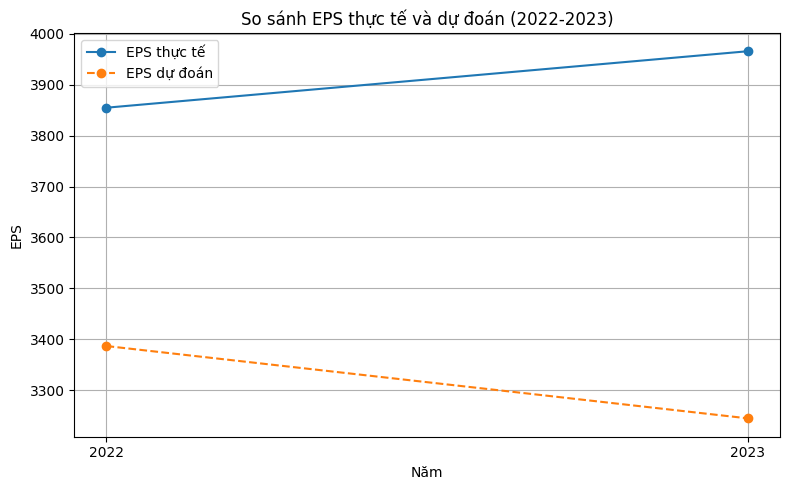

In [2]:
import matplotlib.pyplot as plt

# Lọc dữ liệu cho năm 2022 và 2023
results_filtered = results_rf.iloc[-2:]  # Lấy 2 hàng cuối cùng (2022, 2023)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(results_filtered.index, results_filtered["EPS thực tế"], label="EPS thực tế", marker="o")
plt.plot(results_filtered.index, results_filtered["EPS dự đoán"], label="EPS dự đoán", marker="o", linestyle="--")
plt.title("So sánh EPS thực tế và dự đoán (2022-2023)")
plt.xlabel("Năm")
plt.ylabel("EPS")
plt.xticks(ticks=results_filtered.index, labels=["2022", "2023"])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
def du_doan_eps_nam_tiep_theo(model, data_hien_tai):
    """
    Hàm dự đoán EPS cho năm tiếp theo dựa trên mô hình đã huấn luyện.
    """
    # Chuẩn bị dữ liệu đầu vào cho năm tiếp theo
    data_nam_tiep_theo = data_hien_tai.iloc[-1:].copy()
    data_nam_tiep_theo["Tổng tài sản"] *= 1.1  # Giả định tăng trưởng 10%
    data_nam_tiep_theo["Tổng nợ phải trả"] *= 1.1
    data_nam_tiep_theo["Vốn chủ sở hữu"] *= 1.1
    data_nam_tiep_theo["Thu nhập lãi và các khoản tương tự"] *= 1.1
    data_nam_tiep_theo["Chi phí lãi và tương tự"] *= 1.1
    data_nam_tiep_theo["Lợi nhuận trước thuế"] *= 1.1

    # Tính toán các cột đặc trưng mới
    data_nam_tiep_theo['Tỷ lệ thu nhập/chi phí'] = (
        data_nam_tiep_theo['Thu nhập lãi và các khoản tương tự'] / data_nam_tiep_theo['Chi phí lãi và tương tự']
    )
    data_nam_tiep_theo['Tỷ lệ vốn chủ sở hữu'] = (
        data_nam_tiep_theo['Vốn chủ sở hữu'] / data_nam_tiep_theo['Tổng tài sản']
    )

    # Đảm bảo cột 'Tỷ lệ chi phí/thu nhập' có trong dữ liệu
    if 'Tỷ lệ chi phí/thu nhập' not in data_nam_tiep_theo.columns:
        data_nam_tiep_theo['Tỷ lệ chi phí/thu nhập'] = (
            data_nam_tiep_theo['Chi phí lãi và tương tự'] / data_nam_tiep_theo['Thu nhập lãi và các khoản tương tự']
        )

    # Loại bỏ cột không cần thiết và chỉ giữ lại các cột đã dùng để huấn luyện
    X_nam_tiep_theo = data_nam_tiep_theo[[
        "Tổng tài sản", "Tổng nợ phải trả", "Vốn chủ sở hữu", 
        "Thu nhập lãi và các khoản tương tự", "Chi phí lãi và tương tự", 
        "Lợi nhuận trước thuế", "Tỷ lệ thu nhập/chi phí", 
        "Tỷ lệ vốn chủ sở hữu", "Tỷ lệ chi phí/thu nhập"
    ]].values  # Chuyển thành numpy array

    # Dự đoán EPS cho năm tiếp theo
    eps_du_doan = model.predict(X_nam_tiep_theo)[0]
    return eps_du_doan

In [4]:
# Thêm các cột đặc trưng vào DataFrame
df['Tỷ lệ thu nhập/chi phí'] = df['Thu nhập lãi và các khoản tương tự'] / df['Chi phí lãi và tương tự']
df['Tỷ lệ vốn chủ sở hữu'] = df['Vốn chủ sở hữu'] / df['Tổng tài sản']

# Đảm bảo cột 'Tỷ lệ chi phí/thu nhập' có trong DataFrame
if 'Tỷ lệ chi phí/thu nhập' not in df.columns:
	df['Tỷ lệ chi phí/thu nhập'] = df['Chi phí lãi và tương tự'] / df['Thu nhập lãi và các khoản tương tự']

# Đảm bảo các cột đầu vào khớp với các đặc trưng đã dùng để huấn luyện
required_features = [
	"Tổng tài sản", "Tổng nợ phải trả", "Vốn chủ sở hữu",
	"Thu nhập lãi và các khoản tương tự", "Chi phí lãi và tương tự",
	"Lợi nhuận trước thuế", "Tỷ lệ thu nhập/chi phí",
	"Tỷ lệ vốn chủ sở hữu", "Tỷ lệ chi phí/thu nhập"
]
X_input = df[required_features]

# Gọi hàm để dự đoán EPS cho năm 2024
eps_2024 = du_doan_eps_nam_tiep_theo(best_rf_model, df)
print(f"📈 EPS dự đoán cho năm 2024: {eps_2024:.2f}")

📈 EPS dự đoán cho năm 2024: 3182.76


In [5]:
def du_doan_eps_nam_tiep_theo_nam(model, data_hien_tai, so_nam=3):
    """
    Hàm dự đoán EPS cho nhiều năm tiếp theo dựa trên mô hình đã huấn luyện.
    """
    eps_du_doan = []
    data_du_bao = data_hien_tai.copy()

    for _ in range(so_nam):
        # Chuẩn bị dữ liệu cho năm tiếp theo
        data_nam_tiep_theo = data_du_bao.iloc[-1:].copy()
        data_nam_tiep_theo["Tổng tài sản"] *= np.random.uniform(1.03, 1.15)
        data_nam_tiep_theo["Tổng nợ phải trả"] *= np.random.uniform(1.02, 1.12)
        data_nam_tiep_theo["Vốn chủ sở hữu"] *= np.random.uniform(1.04, 1.14)
        data_nam_tiep_theo["Thu nhập lãi và các khoản tương tự"] *= np.random.uniform(1.04, 1.15)
        data_nam_tiep_theo["Chi phí lãi và tương tự"] *= np.random.uniform(1.02, 1.10)
        data_nam_tiep_theo["Lợi nhuận trước thuế"] *= np.random.uniform(1.05, 1.18)

        # Tính toán các cột đặc trưng mới
        data_nam_tiep_theo['Tỷ lệ thu nhập/chi phí'] = (
            data_nam_tiep_theo['Thu nhập lãi và các khoản tương tự'] / 
            (data_nam_tiep_theo['Chi phí lãi và tương tự'] + 1e-9)
        )
        data_nam_tiep_theo['Tỷ lệ vốn chủ sở hữu'] = (
            data_nam_tiep_theo['Vốn chủ sở hữu'] / 
            (data_nam_tiep_theo['Tổng tài sản'] + 1e-9)
        )
        data_nam_tiep_theo['Tỷ lệ chi phí/thu nhập'] = (
            data_nam_tiep_theo['Chi phí lãi và tương tự'] / 
            (data_nam_tiep_theo['Thu nhập lãi và các khoản tương tự'] + 1e-9)
        )

        # Chỉ giữ lại các cột đã dùng để huấn luyện
        X_nam_tiep_theo = data_nam_tiep_theo[[
            "Tổng tài sản", "Tổng nợ phải trả", "Vốn chủ sở hữu", 
            "Thu nhập lãi và các khoản tương tự", "Chi phí lãi và tương tự", 
            "Lợi nhuận trước thuế", "Tỷ lệ thu nhập/chi phí", 
            "Tỷ lệ vốn chủ sở hữu", "Tỷ lệ chi phí/thu nhập"
        ]].values

        # Dự đoán EPS
        eps = model.predict(X_nam_tiep_theo)[0]
        eps_du_doan.append(eps)

        # Thêm dữ liệu dự đoán vào DataFrame để sử dụng cho năm tiếp theo
        data_nam_tiep_theo["EPS"] = eps
        data_du_bao = pd.concat([data_du_bao, data_nam_tiep_theo], ignore_index=True)

    return eps_du_doan

# Sử dụng mô hình đã huấn luyện để dự đoán EPS cho 3 năm tiếp theo
eps_3_nam_tiep_theo = du_doan_eps_nam_tiep_theo_nam(best_rf_model, df, so_nam=3)

# Hiển thị kết quả
for i, eps in enumerate(eps_3_nam_tiep_theo, start=1):
    print(f"📈 EPS dự đoán cho năm {2024 + i}: {eps:.2f}")

📈 EPS dự đoán cho năm 2025: 3182.76
📈 EPS dự đoán cho năm 2026: 3182.76
📈 EPS dự đoán cho năm 2027: 3436.88
